In [54]:
import numpy as np
import random
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *
import networkx as nx
from utils import *
import time
import sys
import csv
sys.path.insert(1, '../plotting/')
from plotting_functions import *

In [31]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)


In [32]:

def get_secret_key_rate(exp,τ_cut,τ_coh,Le2e,R):
    def rand_repeater_chain(distance,Nrepeater,min_dist = 5):
        repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance
        while np.min(np.diff(repeater_loc))< min_dist:
            repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance    
        return repeater_loc
    
    n = R+1 # number of segments (i.e., no. of repeaters -1 )
    # τ_coh = 0.01
    # τ_cut = 0.1*τ_coh # cutoff
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    if exp =="equal":
        Ls = [Le2e/n]*n
    else:
        locs = rand_repeater_chain(Le2e,R)
        locs = np.array(locs)
        # print(locs)
        point = locs[0]
        repeater_indx = 0
        Ls = []
        for place in locs[1:]:
            # print("length is ",place-point)
            Ls.append(place-point)
            repeater_indx +=1
            point  = place
        Ls = np.array(Ls)
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    return raw_rate_seq,skr_seq[0]


def get_secret_key_rate_without_cutoff(τ_coh,Le2e,R):
    
    def rand_repeater_chain(distance,Nrepeater,min_dist = 5):
        repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance
        while np.min(np.diff(repeater_loc))< min_dist:
            repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance    
        return repeater_loc
    
    n = R+1 # number of segments (i.e., no. of repeaters -1 )
    # τ_coh = 0.01
    # τ_cut = 0.1*τ_coh # cutoff
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    if exp =="equal":
        Ls = [Le2e/n]*n
    else:
        locs = rand_repeater_chain(Le2e,R)
        locs = np.array(locs)
        point = locs[0]
        repeater_indx = 0
        Ls = []
        for place in locs[1:]:
            # print("length is ",place-point)
            Ls.append(place-point)
            repeater_indx +=1
            point  = place
        Ls = np.array(Ls)
    ebit_rate_seq_no_cut, skr_seq_no_cut, _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
    ebit_rate_par_no_cut, skr_par_no_cut, _ = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls)
    return ebit_rate_seq_no_cut,skr_seq_no_cut,ebit_rate_par_no_cut,skr_par_no_cut

def hist(x,y,x2,y2,x_axis_tick_font_size,y_axis_tick_font_size,legend_font_size,num_bins, label,plot_name,image_width, image_lenght):

    n, bin_edges = np.histogram(x, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    fig = plt.figure()
        
            
    fig.set_size_inches(image_width, image_lenght, forward=True) 

    plt.plot(bins_center,n,'-',markersize=2,label=label,color = "C0")

    n, bin_edges = np.histogram(y, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,linestyle="dashed",markersize=2,label=label,color = "C0")

    n, bin_edges = np.histogram(x2, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,'-',markersize=2,label=label,color = "C1")


    n, bin_edges = np.histogram(y2, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,linestyle="dashed",markersize=2,label=label,color = "C1")

    
    my_class_labels = ["Seq, ebit rate","Seq, SKR","Par, ebit rate","Par, SKR"]
    plt.legend([label for label in my_class_labels ],fontsize=legend_font_size)
    plt.rcParams['xtick.labelsize'] = x_axis_tick_font_size 
    #matplotlib.rcParams['text.usetex'] = True
    plt.rcParams['ytick.labelsize']= y_axis_tick_font_size
    plt.xlabel("SKR [1/s]", fontsize=24,labelpad=0)
    #matplotlib.rcParams['text.usetex'] = True
    # fig = plt.figure()
    # plt.set_size_inches(6.4, 3.8, forward=True)# default 
    plt.grid(True)
    plt.tight_layout()
    plt.ylabel("Density function",fontsize=24,labelpad=0)
    plt.tight_layout()
    plt.grid(True)
    plt.grid(which='major', color='#DDDDDD', linewidth=0.6)
    # Show the minor grid as well. Style it in very light gray as a thin,
    # dotted line.
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.4)
    # Make the minor ticks and gridlines show.
    plt.minorticks_on()
    plt.savefig(plot_name)
    # return bins_center

def get_secret_key_rate(exp,τ_cut,τ_coh,Le2e,R):
    def rand_repeater_chain(distance,Nrepeater,min_dist = 5):
        repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance
        while np.min(np.diff(repeater_loc))< min_dist:
            repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance    
        return repeater_loc
    
    n = R+1 # number of segments (i.e., no. of repeaters -1 )
    # τ_coh = 0.01
    # τ_cut = 0.1*τ_coh # cutoff
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    if exp =="equal":
        Ls = [Le2e/n]*n
    else:
        locs = rand_repeater_chain(Le2e,R)
        locs = np.array(locs)
        # print(locs)
        point = locs[0]
        repeater_indx = 0
        Ls = []
        for place in locs[1:]:
            # print("length is ",place-point)
            Ls.append(place-point)
            repeater_indx +=1
            point  = place
        Ls = np.array(Ls)
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    return raw_rate_seq,skr_seq[0]


def get_secret_key_rate_with_cutoff(τ_cut,τ_coh,Le2e,R):
    
    def rand_repeater_chain(distance,Nrepeater,min_dist = 5):
        repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance
        while np.min(np.diff(repeater_loc))< min_dist:
            repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance    
        return repeater_loc
    
    n = R+1 # number of segments (i.e., no. of repeaters -1 )
    # τ_coh = 0.01
    # τ_cut = 0.1*τ_coh # cutoff
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    if exp =="equal":
        Ls = [Le2e/n]*n
    else:
        locs = rand_repeater_chain(Le2e,R)
        locs = np.array(locs)
        point = locs[0]
        repeater_indx = 0
        Ls = []
        for place in locs[1:]:
            # print("length is ",place-point)
            Ls.append(place-point)
            repeater_indx +=1
            point  = place
        Ls = np.array(Ls)
    ebit_rate_seq_no_cut, skr_seq_no_cut, _ = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    ebit_rate_par_no_cut, skr_par_no_cut, _ = T_parallel_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    return ebit_rate_seq_no_cut,skr_seq_no_cut,ebit_rate_par_no_cut,skr_par_no_cut
    

In [ ]:
results_file_path = "random_repeater_placement_with_cutoff.csv"
num_instances = 1000000000
τ_coh = 0.1
τ_cut = 0.01
seq_ebit = np.zeros((num_instances))
seq_skr = np.zeros((num_instances))
par_ebit = np.zeros((num_instances))
par_skr = np.zeros((num_instances))
for i in range(num_instances):
    seq_ebit[i],seq_skr[i],par_ebit[i],par_skr[i] = get_secret_key_rate_with_cutoff(τ_cut,τ_coh,200,5)
    # seq_ebit[i],seq_skr[i],par_ebit[i],par_skr[i] = get_secret_key_rate_without_cutoff(τ_coh,200,5)
    with open(results_file_path, 'a') as newFile:                                
        newFileWriter = csv.writer(newFile)
        newFileWriter.writerow([num_instances,τ_coh,τ_cut,
                                seq_ebit[i],seq_skr[i],par_ebit[i],par_skr[i]])

    print(i,end="\r")
x_axis_tick_font_size =22
y_axis_tick_font_size = 22
legend_font_size = 22


In [59]:
# results_file = "random_repeater_placement_with_cutoff.csv"
results_file = "random_repeater_placement_without_cutoff.csv"
index = 0
with open(results_file, "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        index+=1
num_instances = index
τ_coh = 0.1
τ_cut = 0.01
seq_ebit = np.zeros((num_instances))
seq_skr = np.zeros((num_instances))
par_ebit = np.zeros((num_instances))
par_skr = np.zeros((num_instances))
index = 0
with open(results_file, "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        if index< num_instances:
            seq_ebit[index] = float(line[3])
            seq_skr[index] = float(line[4])
            par_ebit[index] = float(line[5])
            par_skr[index] = float(line[6])
        index+=1
        

x_axis_tick_font_size =22
y_axis_tick_font_size = 22
legend_font_size = 22


we have 155984926 points 


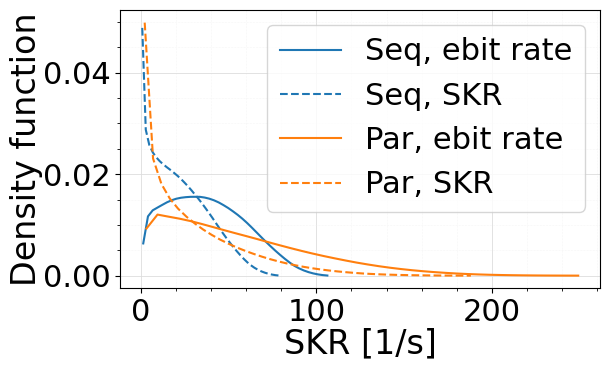

In [51]:
print("we have %s points "%(index))
image_width = 6.2
image_lenght = 3.8
hist(seq_ebit,seq_skr,par_ebit,par_skr,x_axis_tick_font_size,
     y_axis_tick_font_size,legend_font_size,
     40, "raw","../plotting/plots/figure4_with_cutoff_from_file.pdf",
    image_width, image_lenght)


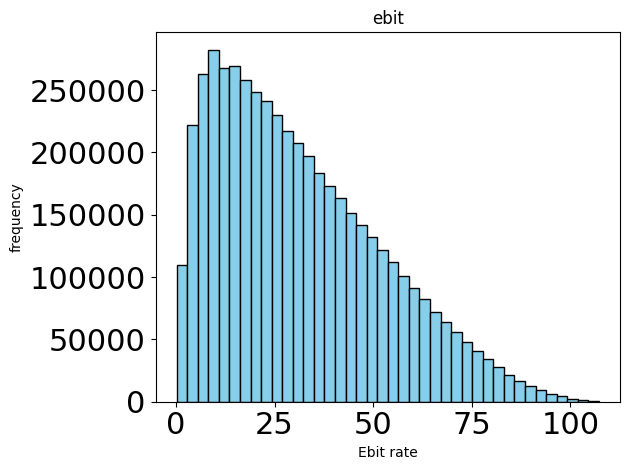

In [55]:
plot_histogram(seq_ebit,40,"Ebit rate","frequency","ebit","../plotting/plots/histogram_with_cutoff_sequential.pdf")


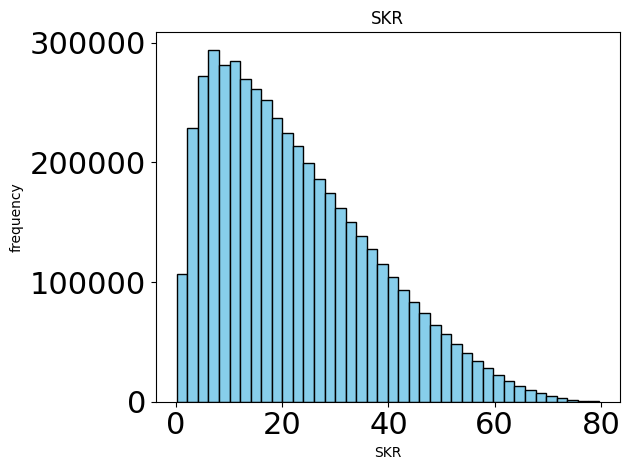

In [56]:
plot_histogram(seq_skr,40,"SKR","frequency","SKR","../plotting/plots/histogram_with_cutoff_sequential_SKR.pdf")


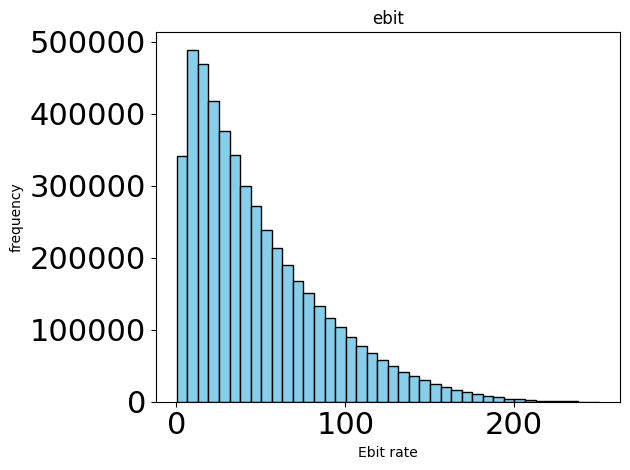

In [57]:
plot_histogram(par_ebit,40,"Ebit rate","frequency","ebit","../plotting/plots/histogram_with_cutoff_parallel_ebit.pdf")


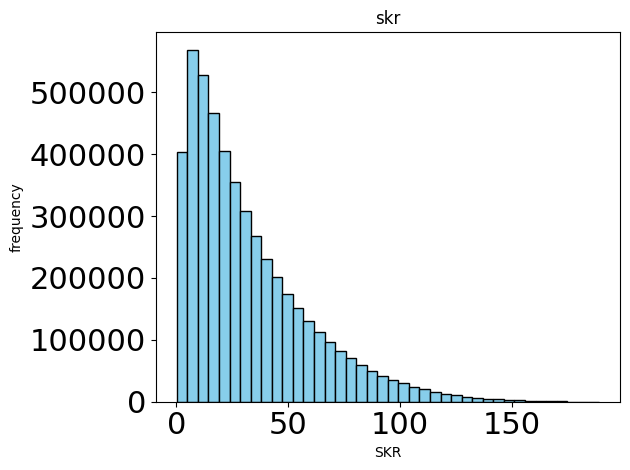

In [58]:
plot_histogram(par_skr,40,"SKR","frequency","skr","../plotting/plots/histogram_with_cutoff_parallel_skr.pdf")
